In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from flowprintOptimal.sekigo.flowUtils.commons import loadFlows, saveFlows
from flowprintOptimal.sekigo.flowUtils.sampler import FixedLengthSampler, FixedLengthSimpleSampler
from flowprintOptimal.sekigo.core.flowRepresentation import FlowRepresentation
from typing import List
from flowprintOptimal.sekigo.flowUtils.flowDatasets import MaxNormalizedDataset,ActivityDataset,BaseFlowDataset,DDQNActivityDataset
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFramePeocessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.flowUtils.commons import getValidInvalidStartingPointsForSubFlowStart, getActivityArrayFromFlow
from flowprintOptimal.sekigo.modeling.models import LSTMModel, RandomForestModel
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMClassifier
from flowprintOptimal.sekigo.modeling.loggers import Logger
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from joblib import delayed, Parallel
from typing import List
from flowprintOptimal.sekigo.earlyClassification.DQL.memoryFiller import MemoryFiller
from flowprintOptimal.sekigo.earlyClassification.DQL.core import MemoryElement,Rewarder
from flowprintOptimal.sekigo.earlyClassification.DQL.datasets import MemoryDataset
from torch.nn.utils.rnn import pack_sequence, unpack_sequence

from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

In [7]:
flows = loadFlows(path= "/Users/rushi/Desktop/UNSW/data/VNAT/flowStore/vnatflows1second.json")

In [8]:
class_type_filtered_flows = VNATDataFrameProcessor.convertLabelsToTopLevel(flows)

In [21]:
sampler = FixedLengthSampler(flow_config= class_type_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .09,min_activity_for_start_point= 30,sample_wise_train_ratio= .8, temporal_train_ratio= 1)

In [22]:
split_flows = sampler.sampleAndCutToLength(data= class_type_filtered_flows)

{'FT': 1, 'chat': 0.04927330363530966, 'control': 0.9588414634146342, 'streaming': 0.5182642131282614}
1
1
1
1
9
1
1
1
1
17
15
8
30
18
30
30
30
1
1
1
1
1
30
1
30
30
1
1
30
3
30
16
17
30
30
16
13
30
19
16
30
6
30
4
13
30
13
20
30
30
1
30
30
30
28
1
2
30
30
30
30
1
1
30
1
1
1
30
1
1
2
1
30
30
1
30
1
1
30
1
1
30
30
30
30
1
30
1
1
30
30
30
1
30
1
1
30
1
1
1
1
30
1
1
30
30
1
30
1
1
30
1
30
30
30
30
30
30
30
1
30
1
30
30
30
30
30
1
1
30
1
1
2
1
1
30
30
30
30
1
1
1
1
30
30
30
1
2
30
30
1
1
1
30
1
1
1
1
30
30
30
3
1
1
30
30
1
30
30
1
30
30
1
1
30
1
30
30
30
30
1
30
1
1
1
6
30
9
30
30
30
30
30
30
30
17
16
30
4
30
30
30
30
30
30
30
30
1
30
9
30
30
8
30
14
7
30
6
8
1
30
1
30
1
30
1
1
1
1
30
30
30
1
1
1
30
30
30
30
30
30
30
1
30
1
30
30
1
1
1
2
1
1
1
1
1
1
1
1
30
30
30
30
2
2
30
1
1
30
1
1
1
1
30
30
1
1
30
1
30
1
1
30
30
1
1
1
1
1
1
20
1
1
1
1
1
1
30
1
1
2
1
3
18
30
1
1
1
1
1
1
30
1
1
1
1
30
1
1
1
1
1
30
1
1
1
30
30
30
1
1
1
30
1
30
1
1
1
30
1
5
1
1
1
1
30
1
1
1
30
1
30
1
30
30
1
1
1
1
30
1
1
1
1


In [23]:
pd.Series(map(lambda x : x.class_type,split_flows["train_flows"])).value_counts()

control      8993
streaming    8479
chat         7708
FT            592
Name: count, dtype: int64

In [24]:
pd.Series(map(lambda x : x.class_type,split_flows["test_flows"])).value_counts()

chat         1770
streaming    1134
control       533
FT             47
Name: count, dtype: int64

In [25]:
train_dataset  = DDQNActivityDataset(split_flows["train_flows"],label_to_index= None)
test_dataset  = DDQNActivityDataset(split_flows["test_flows"],label_to_index= train_dataset.label_to_index)

In [26]:
rewarder = Rewarder(max_length= 30,l= .1,num_labels= len(train_dataset.label_to_index))

In [27]:
memory_filler = MemoryFiller(dataset= train_dataset,rewarder= rewarder, min_length_in_seconds= 5, max_length_in_seconds= 30)

In [28]:
memory = memory_filler.processDataset()

In [29]:
class LSTMClassifier(nn.Module):
    def __init__(self,lstm_input_size,lstm_hidden_size,num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size= lstm_input_size,hidden_size= lstm_hidden_size,batch_first= True)
        self.linear =nn.Sequential( nn.Linear(in_features= lstm_hidden_size,out_features = lstm_hidden_size//2), nn.ReLU(), nn.Linear(lstm_hidden_size//2,num_classes))
        self.softmax = nn.Softmax(dim= -1)
        self.loss_function = nn.CrossEntropyLoss()
        self.mse_loss_function = nn.MSELoss()
        # TODO look at the projection size

    def __unpackAndGetFeatureFromLSTMOutput(self,lstm_out : nn.utils.rnn.PackedSequence):
        lstm_out = unpack_sequence(lstm_out)
        lstm_out = list(map(lambda x : x[-1],lstm_out))
        lstm_out = torch.stack(lstm_out,dim= 0)
        return lstm_out
        
    
    def forward(self,X):
        """
        X is the timeseries input of shape 
        (BS,Seq len, lstm_input_size)
        OR
        packed_sequence

        The output is of shape (BS,num_classes)
        """
        lstm_out, _ = self.lstm(X)
        if isinstance(X,torch.Tensor):
            lstm_out = lstm_out[:,-1,:]
        else:
            lstm_out = self.__unpackAndGetFeatureFromLSTMOutput(lstm_out= lstm_out)
        return self.linear(lstm_out)
    
    def earlyClassificationForward(self,X):
        """
        X is the timeseries input of shape 
        (BS,Seq len, lstm_input_size)
        outputs (BS,seq_len,num_classes)
        """
        
        with torch.no_grad():
            lstm_out, _ = self.lstm(X)
            return self.linear(lstm_out)


    
    def calculateLoss(self,predicted,targets):
        return self.loss_function(predicted,targets).mean()

In [30]:
class DDQNModel:
    def __init__(self,model : LSTMClassifier,memory_dataset : MemoryDataset,train_dataset : BaseFlowDataset,test_dataset : BaseFlowDataset,logger : Logger):
        self.model = model
        self.lag_model = deepcopy(model)
        self.lag_model.eval()
        self.memory_dataset = memory_dataset
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.logger = logger
        

    def trainStep(self,batch : dict,lam : float):
        """
        state and next state is (BS,num_classes)
        """
        state,next_state,action,reward,is_terminal = batch["state"], batch["next_state"], batch["action"], batch["reward"],batch["is_terminal"]
        with torch.no_grad():
            next_state_max_actions_model = torch.argmax(self.model(next_state),dim = -1,keepdim= True)
            next_state_values_lag_model = self.lag_model(next_state)
            next_state_values_for_max_action = torch.gather(input= next_state_values_lag_model, dim= 1, index= next_state_max_actions_model)
            next_state_values_for_max_action = next_state_values_for_max_action*(~(is_terminal.unsqueeze(-1)))
            target = reward + lam*(next_state_values_for_max_action.squeeze())
        
        predicted_values = self.model(state)
        predicted_values_for_taken_action = torch.gather(input= predicted_values, dim= 1,index= action.unsqueeze(-1)).squeeze()
        
        loss = self.model.mse_loss_function(target, predicted_values_for_taken_action.squeeze()).mean()

        return loss
        
    def __refreshLagModel(self):
        self.lag_model = deepcopy(self.model)
        self.lag_model.eval()
    



    def predictStep(self,batch_X):
        """
        Here the return is of shape (BS,seq_len)
        """
        model_out = self.model.earlyClassificationForward(batch_X)
        return torch.argmax(model_out,dim= -1)


    def __processSinglePrediction(self,prediction,num_classes):
        """
        predictions are of shape (seq_len)
        """
        
        for time in range(len(prediction)):
            if prediction[time] < num_classes:
                return (prediction[time],time + 1)
        
        return (-1,len(prediction))
        
    def predictOnDataset(self,dataset : BaseFlowDataset):
        dataloader = DataLoader(dataset= dataset, batch_size = 64)
        with torch.no_grad():

            labels = []
            predictions = []
            for batch in dataloader:
                batch_X,batch_y = batch["flow"].float(), batch["label"]
                predicted = self.predictStep(batch_X = batch_X).numpy() # (BS,seq_len)
                processed_predictions = map(lambda x : self.__processSinglePrediction(x,len(dataset.label_to_index)), predicted)

                predictions.extend(processed_predictions)
                labels.extend(batch_y.numpy().tolist())

        
        return predictions


    def eval(self,dataset : BaseFlowDataset):
        predictions = self.predictOnDataset(dataset= dataset)
        labels = list(map(lambda x : x["label"], dataset))

        predicted_labels,time = [],[]

        for i in range(len(predictions)):
            predicted_labels.append(predictions[i][0])
            time.append(predictions[i][1])
        _,_,f1,_ = precision_recall_fscore_support(labels, predicted_labels, average= "weighted",zero_division=0)
        average_time = sum(time)/len(time)
        return f1,average_time
    

    def evalTrain(self):
        f1,average_time = self.eval(dataset= self.train_dataset)
        self.logger.addMetric(metric_name= "train_eval_f1", value= f1)
        self.logger.addMetric(metric_name= "train_eval_time", value= average_time)

    def evalTest(self):
        f1,average_time = self.eval(dataset= self.test_dataset)
        self.logger.addMetric(metric_name= "test_eval_f1", value= f1)
        self.logger.addMetric(metric_name= "test_eval_time", value= average_time)

    def train(self,epochs : int,batch_size = 64,lr = .001,lam = .99,model_lag_in_steps = 50):
        # TODO add batch_sampler
        """
        Can stress enough how important the shuffle == True is in the Dataloader
        """
        train_dataloader = DataLoader(dataset= self.memory_dataset,collate_fn= self.memory_dataset.collateFn,batch_size= batch_size,drop_last= True,shuffle= True)
        optimizer = torch.optim.Adam(params= self.model.parameters(), lr= lr)
        steps_loss,counter = 0,0
        steps = 0

        for epoch in range(epochs):
            for batch in train_dataloader:
                loss = self.trainStep(batch= batch,lam= lam)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                steps_loss += loss.item()

                steps += 1
                counter += 1
                if steps%100 == 0:
                    steps_loss /= counter
                    self.logger.addMetric(metric_name= "train_loss", value= steps_loss)
                    steps_loss = 0
                    counter = 0
                
                if steps%200 == 0:
                    self.evalTest()
                    
                if steps%model_lag_in_steps == 0:
                    self.__refreshLagModel()
                
            








In [34]:
memory_dataset = MemoryDataset(memories= memory,num_classes= len(train_dataset.label_to_index) + 1)
model = LSTMClassifier(lstm_hidden_size= 64,lstm_input_size= 6,num_classes= 5)
logger = Logger(verbose= True)

In [35]:
ddq_model = DDQNModel(model= model, memory_dataset= memory_dataset,train_dataset= train_dataset,test_dataset= test_dataset,logger= logger)

In [ ]:
ddq_model.train(epochs= 10,batch_size= 64,model_lag_in_steps= 100,lr= .0005)

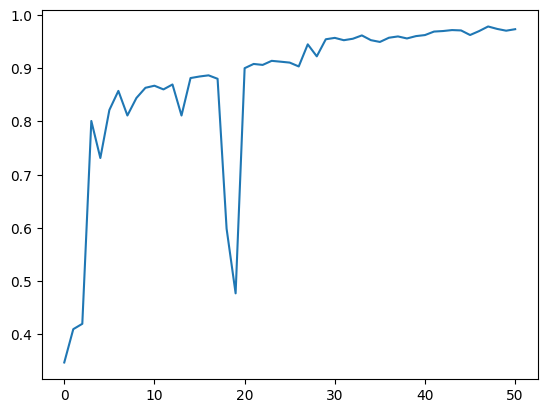

In [37]:
plt.plot(logger.getMetric("test_eval_f1"))

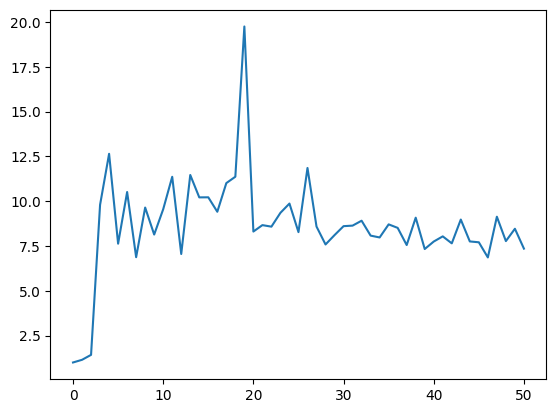

In [38]:
plt.plot(logger.getMetric("test_eval_time"))

In [40]:
ddq_model.evalTrain()

1 metric train_eval_f1 = 0.9704953661916055
1 metric train_eval_time = 7.7801878007139535


In [39]:
ddq_model.evalTest()

52 metric test_eval_f1 = 0.9739924275158436
52 metric test_eval_time = 7.316877152698048


In [41]:
test_loader = DataLoader(dataset= test_dataset,batch_size= 64,shuffle= False)

In [42]:
def getPrediction(preds,num_classes):
    for p in preds:
        if p < num_classes:
            return p
    return -1

def getPredictionTail(preds,num_classes):
    for p in reversed(preds):
        if p < num_classes:
            return p
    return -1

def predictionConsistency(pred : list,num_classes):
    is_predicted = None
    is_consistent = True
    for i,p in enumerate(pred):
        if p < num_classes:
            if is_predicted == None:
                is_predicted = (i+1,p)
            elif is_predicted[1] == p:
                continue
            else:
                is_consistent = False
                break
        
    return is_consistent


def strongPredictionConsistency(pred : list,num_classes):
    is_predicted = None
    is_consistent = True
    for i,p in enumerate(pred):
        if is_predicted == None:
            if p < num_classes:
                is_predicted = p
        else:
            if p != is_predicted:
                is_consistent = False
                break
        
    return is_consistent

def awarenessCheck(batch_preds : list,labels : list):
    is_aware = []
    for i in range(len(batch_preds)):
        if labels[i] in batch_preds[i]:
            is_aware.append(True)
        else:
            is_aware.append(False)

    return is_aware

In [43]:
preds = []
tail_preds = []
labels = []
consistencies = []
awareness = []
original_preds = []

for batch in test_loader:
    batch_preds = ddq_model.predictStep(batch["flow"].float()).numpy().tolist()
    batch_labels = batch["label"].numpy().tolist()
    original_preds.extend(batch_preds)
    preds.extend(list(map(lambda x : getPrediction(x,len(test_dataset.label_to_index)),batch_preds)))
    tail_preds.extend(list(map(lambda x : getPredictionTail(x,len(test_dataset.label_to_index)),batch_preds)))
    labels.extend(batch_labels)
    awareness.extend(awarenessCheck(batch_preds= batch_preds,labels= batch_labels))

    consistencies.extend(list(map(lambda x : strongPredictionConsistency(x,len(test_dataset.label_to_index)),batch_preds)))

In [44]:
preds = np.array(preds)
tail_preds = np.array(tail_preds)
labels = np.array(labels)
consistencies = np.array(consistencies)
awareness = np.array(awareness)

In [45]:
awareness.sum()/awareness.shape

array([0.98450057])

In [46]:
(preds == labels).sum()/preds.shape

array([0.9750287])

In [47]:
consistencies.sum()/consistencies.shape

array([0.8315155])

In [48]:
((~consistencies) & (preds == labels)).sum()/(~consistencies).sum()

0.9080068143100511

In [49]:
((preds != labels) & (tail_preds == labels) & (~consistencies)).sum()/(preds != labels).sum()

0.367816091954023

In [72]:
for pred,label in zip(preds,labels):
    predictionConsistency(pred,label,num_classes= len(test_dataset.label_to_index))

NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 3
incirrect (6, 0) 2
NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 3
incirrect (9, 0) 1
NOT PREDICTED 3
(14, 0) (30, 1) 3
incirrect (14, 0) 3
NOT PREDICTED 3
NOT PREDICTED 3
(11, 1) (30, 0) 1
NOT PREDICTED 3
(8, 0) (23, 1) 1
incirrect (8, 0) 1
NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 3
NOT PREDICTED 1
NOT PREDICTED 3
